# Heartbeat Sounds Classification using Machine Learning
DSI 13 Capstone Project: Classifying heartbeat anomalies from stethoscope audio
**Notebook 3c: Modelling - CWT XGBOOST**

## Importing Libraries

In [ ]:
# for me, I need to run extral step before can do pip install in terminal
# the step is listed in the last line of this notebook
#!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
#import scipy
#from scipy.signal import welch

## plot
import matplotlib.pyplot as plt
import seaborn as sns

## others
#from glob import glob
import itertools


# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

## xgboost
from xgboost import XGBClassifier
from xgboost import plot_tree, plot_importance

#To visualize the whole grid
pd.options.display.max_columns = 999

%matplotlib inline
%pylab inline

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Reload the preprocessed data from notebook 2

In [2]:
### Load data
%store -r X_train_cwt 
%store -r X_test_cwt 
%store -r y_train 
%store -r y_test 
%store -r X_aunlabel_cwt
%store -r X_bunlabel_cwt
%store -r le
%store -r class_weights

# 5.4 XGBOOST using CWT feature

**eXtreme Gradient Boosting or XGBOOST** is a gradient boosting, decision tree-based ensemble machine learning algorithm. Gradient Boosting Machines fit into a category of ML called Ensemble Learning, which is a branch of ML methods that train and predict with many models at once to produce a single superior output.

**Feature selection**: Here I will reuse the **CWT features**, but apply **PCA** to extract the important feature to achieve dimentionality reduction before passing to XGBOOST Classifier for modelling.
In addition, I will only work on dataset with syntheisize audio + oversampling, since both MFCC+CNN and CWT+CNN results shown that model is able to classifying the minority class better with imbalance class treatment.

Source:
[Intro to Classification and Feature Selection with XGBoost](https://www.aitimejournal.com/@jonathan.hirko/intro-to-classification-and-feature-selection-with-xgboost)

# 5.4.1 X_train (Synthesize and Oversampling)

## 5.4.1.1 Feature Extraction using Principal Components Analysis (PCA)

The CWT features from previous 5.3 CNN modelling section are 2D CWT coefficients which form an scaleogram image. 
Instead of the 2D (150 x 150) features, I apply PCA to extract the features with the highest variation in each scale, and resulted in 1D features (150).

In [3]:
### Function to perform PCA
def pca_cwt(X):
    
    # Reshape X from 4D to 3D
    X = np.reshape(X, (-1, X.shape[1], X.shape[2]))
    
    # apply PCA for just a single component to get the most significant coefficient per scale (period/frequency)
    pca = PCA(n_components=1)
    
    # set an empty array (0,150), which will then stack the PCA component for each samples (number of sample = number for rows in X.shape[0])
    pca_comps = np.empty((0, X.shape[1]), dtype = 'float32')
    for sample in range(X.shape[0]):
        pca_comps = np.vstack([pca_comps, pca.fit_transform(X[sample]).flatten()])
        
    return pca_comps

In [4]:
%%time
### Feature Extraction from X_train_cwt and X_test_cwt using PCA

X_train_pca = pca_cwt(X_train_cwt)
print(f"X_train_pca: {X_train_pca.shape}")
X_test_pca = pca_cwt(X_test_cwt)
print(f"X_test_pca: {X_test_pca.shape}")

X_train_pca: (854, 120)
X_test_pca: (117, 120)
CPU times: user 6.11 s, sys: 591 ms, total: 6.7 s
Wall time: 3.5 s


## 5.4.1.2 y_label

- The y_train_cwt and y_test_cwt shape: (rows x5), were dummy coded with the 5 classes to 5 column. 
- Below cell revert them into numerical category, resulted in 1D np.array

In [5]:
### Function to convert y_label from dummies coded 5 col to numerical category in 1D np array
def convert_ylabel(ytrain, ytest):
    y_train_pca, y_test_pca = [],[]
    
    for i in range(ytrain.shape[0]):
        y_train_pca.append(np.argmax(ytrain[i]))
    for j in range(ytest.shape[0]):
        y_test_pca.append(np.argmax(ytest[j]))
        
    # change to 1D np.array
    y_train_pca = np.array(y_train_pca)
    y_test_pca = np.array(y_test_pca)
    
    print(f"ytrain pca : {y_train_pca.shape}")
    print(f"ytest pca : {y_test_pca.shape}")
    
    return y_train_pca, y_test_pca

In [6]:
y_train_pca, y_test_pca = convert_ylabel(y_train, y_test)

ytrain pca : (854,)
ytest pca : (117,)


In [8]:
### Calculate class weight for y_train_pca
classes = le.classes_
train_weight = [class_weights[x] for x in y_train_pca]
test_weight = [class_weights[x] for x in y_test_pca]

## 5.4.1.3 XGBOOST Modeling


#### Instantiate model

In [9]:
xgb = XGBClassifier(max_depth = 5, 
                    objective = 'multi:softmax', #multiclass classification using the softmax 
                    num_class = 5, 
                    subsample = 0.5,   #Subsample ratio of the training instances.
                    n_estimators = 120)

#### Fit model

In [10]:
history = xgb.fit(X_train_pca, y_train_pca, 
                    eval_metric = ["merror"],     #multiclass error
                    eval_set = [(X_train_pca, y_train_pca), (X_test_pca, y_test_pca)],
                    sample_weight_eval_set = [train_weight, test_weight],
                    verbose = True)

[0]	validation_0-merror:0.18244	validation_1-merror:0.49790
[1]	validation_0-merror:0.12497	validation_1-merror:0.48129
[2]	validation_0-merror:0.10903	validation_1-merror:0.44986
[3]	validation_0-merror:0.08996	validation_1-merror:0.49255
[4]	validation_0-merror:0.07147	validation_1-merror:0.51942
[5]	validation_0-merror:0.06967	validation_1-merror:0.52187
[6]	validation_0-merror:0.07046	validation_1-merror:0.53391
[7]	validation_0-merror:0.04623	validation_1-merror:0.52510
[8]	validation_0-merror:0.04416	validation_1-merror:0.53391
[9]	validation_0-merror:0.04611	validation_1-merror:0.53001
[10]	validation_0-merror:0.03766	validation_1-merror:0.52365
[11]	validation_0-merror:0.03580	validation_1-merror:0.51484
[12]	validation_0-merror:0.03073	validation_1-merror:0.51730
[13]	validation_0-merror:0.02470	validation_1-merror:0.51730
[14]	validation_0-merror:0.02105	validation_1-merror:0.51730
[15]	validation_0-merror:0.02034	validation_1-merror:0.53001
[16]	validation_0-merror:0.01891	v

### Calculate the Accuracy Score: `X_test_pca`

In [11]:
### predict X_test_pca
ytrain_pred = xgb.predict(X_train_pca)
ytest_pred = xgb.predict(X_test_pca)

### calculate the Accuracy score of X_test_pca
train_acc = accuracy_score(y_train_pca, ytrain_pred)
test_acc = accuracy_score(y_test_pca, ytest_pred)
print(f"pca accuracy: {round(train_acc, 3)}")
print(f"pca accuracy: {round(test_acc, 3)}")

pca accuracy: 1.0
pca accuracy: 0.547


## 5.4.1.4 Model Evaluation: `XGBOOST Report`

- `Normal`, precision = 68% (mfcc model6 = 78%, cwt model6 = 73%).
- `Murmur`, precision = 40% (mfcc model6 = 81%, cwt model6 = 80%).
- `extrahls`, `extrastole` precision = 0%, 25%((mfcc model6 = 25% & 17%, respectively)
- `Artifact`, precision 58% (mfcc model6 = 50%, cwt model6 = 62%).
- Overall accuracy = 55% (mfcc model6 = 70%, cwt model6 = 59%).

Model not performing better compared to mfcc cnn, and cwt cnn.

In [13]:
classes = le.classes_
convert_label = lambda x: classes[x]
print(classification_report(convert_label(y_test_pca), convert_label(ytest_pred)))

              precision    recall  f1-score   support

    artifact       0.58      0.88      0.70         8
    extrahls       0.00      0.00      0.00         4
  extrastole       0.25      0.33      0.29         9
      murmur       0.40      0.31      0.35        26
      normal       0.68      0.66      0.67        70

    accuracy                           0.55       117
   macro avg       0.38      0.43      0.40       117
weighted avg       0.55      0.55      0.55       117



### Confusion Matrix

In [14]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

    plt.show()

### Confusion Matrix
- Results show that the model predict most of the audio from the majority class, that is `Normal` category. This is not desirable.
- Asides, the train accuracy > test accuracy, which indicated the model is overfitting.

[[ 7  0  0  1  0]
 [ 0  0  0  1  3]
 [ 0  0  3  0  6]
 [ 1  1  3  8 13]
 [ 4  4  6 10 46]]


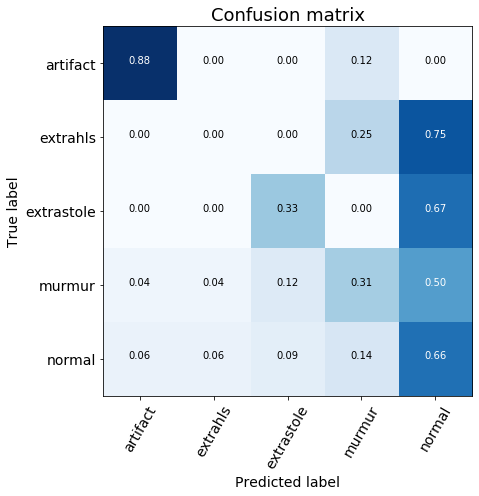

In [15]:
### Confusion Matrix from PCA
cnf_matrix = confusion_matrix(y_test_pca, ytest_pred)
print(cnf_matrix)

### Plot confusion matrix
cnf_matrix = cnf_matrix.astype(float) / cnf_matrix.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cnf_matrix, classes)

## 5.4.1.5 Hyperparameter Optimization using RandomizedSearchCV

### Set hyperparameters that would like to optimize using RandomizedSearchCV

In [16]:
params = {
    "eta" : [0.0001, 0.001, 0.01, 0,1],
    "gamma" : [0.001, 0.01, 0.05, 0.1, 0.3], 
    "max_depth":[5, 7, 8, 9, 10, 11],
    "colsample_bytree": [0.3, 0.5, 0.6, 0.8],
    "subsample" : [0.3, 0.5,0.6,0.8],
    "reg_alpha" : [0.0, 0.5],
    "reg_lambda" : [1, 1.5, 2],
    "n_estimators" : [40, 50, 60, 80, 100, 120]  
    }

In [17]:
xgb_clf = XGBClassifier(objective = 'multi:softmax', eval_metric = ["merror", "map", "auc"])
### Create RandomizedSearchCV

rscv = RandomizedSearchCV(xgb_clf , 
                      param_distributions= params, cv = 3, verbose =3)
model_xgboost = rscv.fit(X_train_pca, y_train_pca)

# model best estimators
print(f"best estimator: {model_xgboost.best_params_}")
print(f"best score: {model_xgboost.best_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] subsample=0.6, reg_lambda=1.5, reg_alpha=0.0, n_estimators=50, max_depth=11, gamma=0.1, eta=0, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.6, reg_lambda=1.5, reg_alpha=0.0, n_estimators=50, max_depth=11, gamma=0.1, eta=0, colsample_bytree=0.3, score=0.224, total=   0.6s
[CV] subsample=0.6, reg_lambda=1.5, reg_alpha=0.0, n_estimators=50, max_depth=11, gamma=0.1, eta=0, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  subsample=0.6, reg_lambda=1.5, reg_alpha=0.0, n_estimators=50, max_depth=11, gamma=0.1, eta=0, colsample_bytree=0.3, score=0.225, total=   0.6s
[CV] subsample=0.6, reg_lambda=1.5, reg_alpha=0.0, n_estimators=50, max_depth=11, gamma=0.1, eta=0, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  subsample=0.6, reg_lambda=1.5, reg_alpha=0.0, n_estimators=50, max_depth=11, gamma=0.1, eta=0, colsample_bytree=0.3, score=0.225, total=   0.6s
[CV] subsample=0.3, reg_lambda=1, reg_alpha=0.0, n_estimators=60, max_depth=7, gamma=0.05, eta=1, colsample_bytree=0.6 
[CV]  subsample=0.3, reg_lambda=1, reg_alpha=0.0, n_estimators=60, max_depth=7, gamma=0.05, eta=1, colsample_bytree=0.6, score=0.815, total=   0.6s
[CV] subsample=0.3, reg_lambda=1, reg_alpha=0.0, n_estimators=60, max_depth=7, gamma=0.05, eta=1, colsample_bytree=0.6 
[CV]  subsample=0.3, reg_lambda=1, reg_alpha=0.0, n_estimators=60, max_depth=7, gamma=0.05, eta=1, colsample_bytree=0.6, score=0.792, total=   0.5s
[CV] subsample=0.3, reg_lambda=1, reg_alpha=0.0, n_estimators=60, max_depth=7, gamma=0.05, eta=1, colsample_bytree=0.6 
[CV]  subsample=0.3, reg_lambda=1, reg_alpha=0.0, n_estimators=60, max_depth=7, gamma=0.05, eta=1, colsample_bytree=0.6, score=0.835, total=   0.5s
[CV] subsample=0.5, reg_lambda=1, reg_alpha=0.

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   32.0s finished


best estimator: {'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 40, 'max_depth': 7, 'gamma': 0.3, 'eta': 1, 'colsample_bytree': 0.8}
best score: 0.8290398126463701


In [18]:
### RandomSearchCV results
print(f"train score: {round(model_xgboost.best_score_, 3)}")
print(f"test score: {round(model_xgboost.score(X_test_pca, y_test_pca),3)}")

train score: 0.829
test score: 0.53


## 5.4.1.6 XGBOOST with optimal hyperparameter from RandomizedSearchCV

### Instantiate model with optimal hyperparameter

In [19]:
xgb2 = XGBClassifier(max_depth = 7, 
                    objective = 'multi:softmax', #multiclass classification using the softmax 
                    num_class = 5, 
                    subsample = 0.5, colsample_bytree = 0.8,   
                    n_estimators = 40,
                    eta = 1, gamma = 0.3,
                    reg_alpha = 0.5, reg_lambda = 1)

In [20]:
history2 = xgb2.fit(X_train_pca, y_train_pca, 
                    eval_metric = ["merror"],     #multiclass error
                    eval_set = [(X_train_pca, y_train_pca), (X_test_pca, y_test_pca)],
                    sample_weight_eval_set = [train_weight, test_weight],
                    verbose = True)

[0]	validation_0-merror:0.15896	validation_1-merror:0.56436
[1]	validation_0-merror:0.09291	validation_1-merror:0.55834
[2]	validation_0-merror:0.07215	validation_1-merror:0.55265
[3]	validation_0-merror:0.05675	validation_1-merror:0.58363
[4]	validation_0-merror:0.03415	validation_1-merror:0.56602
[5]	validation_0-merror:0.02843	validation_1-merror:0.56602
[6]	validation_0-merror:0.01999	validation_1-merror:0.58363
[7]	validation_0-merror:0.01396	validation_1-merror:0.56212
[8]	validation_0-merror:0.00821	validation_1-merror:0.56847
[9]	validation_0-merror:0.00892	validation_1-merror:0.55821
[10]	validation_0-merror:0.00678	validation_1-merror:0.55186
[11]	validation_0-merror:0.00801	validation_1-merror:0.54941
[12]	validation_0-merror:0.00535	validation_1-merror:0.54305
[13]	validation_0-merror:0.00507	validation_1-merror:0.54060
[14]	validation_0-merror:0.00607	validation_1-merror:0.55576
[15]	validation_0-merror:0.00337	validation_1-merror:0.54305
[16]	validation_0-merror:0.00337	v

### Calculate the Accuracy Score: `X_test_pca` 

In [21]:
### predict X_test_pca
ytrain_pred_pca2 = xgb2.predict(X_train_pca)
ytest_pred_pca2 = xgb2.predict(X_test_pca)

### calculate the Accuracy score of X_test_pca
train_pca2_acc = accuracy_score(y_train_pca, ytrain_pred_pca2)
test_pca2_acc = accuracy_score(y_test_pca, ytest_pred_pca2)
print(f"pca2 train accuracy: {round(train_pca2_acc, 3)}")
print(f"pca2 test accuracy: {round(test_pca2_acc, 3)}")

pca2 train accuracy: 0.999
pca2 test accuracy: 0.53


## 5.4.7 Model Evaluation: `XGBOOST with optimal hyperparameter Report`

- `Normal`, precision = 68% (mfcc model6 = 80%, cwt model6 = 83%).
- `Murmur`, precision = 37% (mfcc model6 = 65%, cwt model6 = 55%).
- `extrahls`, `extrastole` precision = 25%, 31%((mfcc model6 = 20% & 67%, respectively)
- `Artifact`, precision 64% (mfcc model6 = 50%, cwt model6 = 53%).
- Overall accuracy = 56% (mfcc model6 = 68%, cwt model6 = 58%).

Model not performing better compared to mfcc cnn, and cwt cnn. But it does performing slightly better after hyperparameter tunning.

In [22]:
convert_label = lambda x: classes[x]
print(classification_report(convert_label(y_test_pca), convert_label(ytest_pred_pca2)))

              precision    recall  f1-score   support

    artifact       0.58      0.88      0.70         8
    extrahls       0.17      0.25      0.20         4
  extrastole       0.12      0.11      0.12         9
      murmur       0.32      0.27      0.29        26
      normal       0.67      0.66      0.66        70

    accuracy                           0.53       117
   macro avg       0.37      0.43      0.39       117
weighted avg       0.52      0.53      0.52       117



[[ 7  0  0  1  0]
 [ 0  1  0  1  2]
 [ 0  0  1  1  7]
 [ 1  1  3  7 14]
 [ 4  4  4 12 46]]


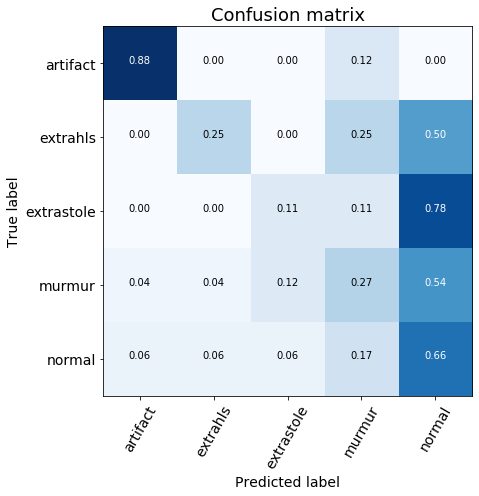

In [25]:
### Confusion Matrix from PCA
cnf_matrix2 = confusion_matrix(y_test_pca, ytest_pred_pca2)
print(cnf_matrix2)

classes = le.classes_
### Plot confusion matrix
cnf_matrix2 = cnf_matrix2.astype(float) / cnf_matrix2.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cnf_matrix2, classes)

### Category that was wrongly classify by CWT_XGBOOST model

In [27]:
### View the class with WRONG classification
cwt_xgboost_pred_result = list(zip(convert_label(y_test_pca), convert_label(ytest_pred_pca2)))
cwt_xgboost_result_df = pd.DataFrame(cwt_xgboost_pred_result, columns = ['label', 'pred_label'])
num_wrong = cwt_xgboost_result_df[cwt_xgboost_result_df['label'] != cwt_xgboost_result_df['pred_label']].shape[0]
print(f"number of wrong prediction: {num_wrong}/{cwt_xgboost_result_df.shape[0]}")

cwt_xgboost_result_df[cwt_xgboost_result_df['label'] != cwt_xgboost_result_df['pred_label']]

number of wrong prediction: 55/117


,label,pred_label
2,normal,artifact
4,normal,artifact
7,extrastole,normal
8,artifact,murmur
9,normal,murmur
10,normal,murmur
12,extrahls,murmur
15,normal,extrahls
16,murmur,extrastole
20,murmur,normal


## 5.4.8 Unlabel data prediction

In [28]:
### Load unlabel data

%store -r X_aunlabel_cwt
%store -r X_bunlabel_cwt

In [29]:
### PCA feature extraction

X_aunlabel_pca = pca_cwt(X_aunlabel_cwt)
X_bunlabel_pca = pca_cwt(X_bunlabel_cwt)

print(f"X_aunlabel_pca: {X_aunlabel_pca.shape}")
print(f"X_aunlabel_pca: {X_bunlabel_pca.shape}")

X_aunlabel_pca: (52, 120)
X_aunlabel_pca: (195, 120)


In [30]:
### Predict unlabel audio and export results to csv file
from keras.utils import to_categorical
model_list = [xgb, xgb2]
seta_col = ['normal', 'murmur', 'extrahls', 'artifact']   # col list from kaggle's evaluation_sheet
setb_col = ['normal', 'murmur', 'extrastole']

for i in range(2):
    pred_a = model_list[i].predict(X_aunlabel_pca)
    pred_b = model_list[i].predict(X_bunlabel_pca)
    
    ### to dummies
    pred_a = to_categorical(pred_a)
    pred_b = to_categorical(pred_b)
    
    ### to df
    pred_a_df = pd.DataFrame(pred_a.astype(int), columns= classes)
    pred_a_df = pred_a_df[seta_col]
    pred_b_df = pd.DataFrame(pred_b.astype(int), columns= classes)
    pred_b_df = pred_b_df[setb_col]
    
    ### export to csv
    name_a = '../outputs/kaggle_eval/xgb_seta' + str(i+5) + '.csv'
    name_b = '../outputs/kaggle_eval/xgb_setb' + str(i+5) + '.csv'
    pred_a_df.to_csv(name_a, index = False)
    pred_b_df.to_csv(name_b, index = False)

Using TensorFlow backend.


#### Appendix: My step to install xgboost

1. brew install cmake 
2. brew install gcc@8
3. git clone --recursive https://github.com/dmlc/xgboost
4. mkdir xgboost/my_build
5. cd xgboost/my_build
6. CC=gcc-8 CXX=g++-8 cmake ..
7. make -j4
8. pip install xgboost